# Giorgio Mendoza
# CS539-F23-F02
# Dr. J. Sethi

# Lab: Clustering via k-means

This lab will look at one of the fundamental algorithms in machine learning, `k-Means` that is used for clustering. Clustering is essentially the idea of grouping similar things together.
The main purpose of this tutorial is to get an introduction to k-Means from the ground up, just as we did for `kNN` earlier, except we'll actually delve into the code this time around.

The pedagogical basis of this lab is to asynchronously simulate a discussion between the student and instructor/TA. Thus, the idea is for you to build up intuition for the algorithm by making a guess and then comparing to the given suggested answer/suggestion for next steps to see if your intuition matches up (or perhaps is better!) with an "expert" answer. This lab is designed to be a little different from the other labs so as to vary up the pedagogical approach rather than have all the labs following the same format but, as they say, your mileage may vary!

## Submission

All you have to submit for this lab is the answers to the questions in the "Implicit Preference" sections at the end. For those questions, please give your initial sense of each question as you build up intuition for this algorithm. Some of those questions have an initial next step and your intuition might be more or less detailed than that next step suggestion and that's totally okay.

## The main idea
The central idea of `k-Means` is to group data into a given number of clusters, `k`,  that's provided as input. The approach is to start by picking `k` random points as the centers for each of those `k` clusters. For each data point in the dataset, we find the cluster whose center is closest to the given data point and assign the data point to that cluster. Next, we compute the mean, or average, of all the points assigned to each "cluster" and use that mean as the new center for that cluster. We then repeat this entire process until the assignment of data points no longer changes and the centers converge to a stable position.

Here is some pseudocode for the `k-Means` algorithm:

In [ ]:
centers <-- pick k initial Centers

while (centers are changing) {
	// Compute the assignments
	asg <-- [(x, nearest(centers, x)) for x in data]

	// Compute the new centers
	for j in range(k):
		centers[j] = mean([x for (x, c) in asg if c == j])
}

This is guaranteed to converge to a local optimum although it does depend upon the choice of initial centers which, if they're particularly unlucky, can have slow convergence and might get stuck in a bad local optimum. There are no formal approaches to choosing `k` but a good heuristic is to use the Elbow Method where you try a range of `k` values and plot the average distance to centers versus `k` and then pick the inflection point for a reasonable  `k` value to use.

Okay, enough setup... let's get to the code!

## Initial code setup

We'll need to add in some helper functions so let's just put them all in here first:

In [5]:
#import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

colors = plt.cm.Dark2

def FXNscatter2d_grouped(x, g):
    n_groups = len(np.unique(g))

    for i in range(n_groups):
        plt.scatter(x[g==i, 0], x[g==i, 1],
                    color = colors(1.*i/n_groups),
                    label = "{}".format(i))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

class CLSkmeans(object):
    def __init__(self, data, k, centers=None, max_iterations=1000, verbose=False):
        self.k = k
        self.data = data
        self.iterations = 0
        self.converged = False
        self.max_iterations = max_iterations
        self.verbose = verbose

        if  centers is not None:
            self.centers = centers
        else:
            self.centers = self._init_random_centers()
        self.clusters = -np.ones(data.shape[0])
        self._update_dist()

    def _init_random_centers(self):
        """
        Returns k centers by choosing random data points
        """
        nrows = self.data.shape[0]
        randomRows = np.random.choice(nrows, size = self.k, replace = False)
        return self.data[randomRows]

    def _update_dist(self):
        """
        Calculates square distances from individual points to centers
        and stores the values in a matrix.

        Rows index the points while columns index the centers
        """
        self.dist = np.sum((self.data[:, np.newaxis] - self.centers)**2, axis=2)

    def _update_clusters(self):
        """
        Updates cluster assignments using distances.  Ties are broken randomly
        """
        def find_min_center(dists):
            minimizing_clusters = np.where(dists == np.min(dists))[0]
            if len(minimizing_clusters) == 1:
                return(minimizing_clusters)
            else:
                return np.random.choice(minimizing_clusters, size=1)

        self.clusters = np.apply_along_axis(find_min_center, 1, self.dist).ravel()

    def _update_centers(self):
        """
        Updates the centers by finding the means within clusters
        """
        self.centers = np.array([
            self.data[self.clusters == c].mean(axis=0)
            for c in  range(self.k)
        ])
        self._update_dist()

    def _update_sse(self):
        """
        Calculates the within-cluster sum of squares
        """
        self.css = np.array([
            self.dist[self.clusters == c, c].sum()
            for c in  range(self.k)
        ])
        self.wss = self.css.sum()

    def show_sse(self):
        self._update_sse()
        print("Cluster Sum of Squares:")
        for c in range(self.k):
            print("Cluster {}: {}".format(c, self.css[c]))
        print("Total Cluster Sum of Squares: {}".format(self.wss))
        print("\n")

    def show_clusters(self):
        print("Assignments:")
        for c in range(self.k):
            members = np.where(self.clusters == c)[0]
            print("Cluster {}: {}".format(c, members))
        print("\n")

    def show_centers(self):
        print("Centers:")
        for c in range(self.k):
            print("Cluster {}: {}".format(c, self.centers[c]))
        print("\n")

    def summary(self):
        print("Current Iteration: {}".format(self.iterations))
        self.show_clusters()
        self.show_centers()
        self.show_sse()

    def plot(self, colored=True):
        if colored:
            FXNscatter2d_grouped(self.data, self.clusters)
        else:
            plt.scatter(self.data[:,0], self.data[:,1],
                        color = colors(.5))
        plt.scatter(self.centers[:,0], self.centers[:,1],
                    color = 'black', marker = 'x', s = 200)

    def step(self):
        old_clusters = self.clusters.copy()

        self._update_clusters()
        self._update_centers()

        self.converged = np.all(old_clusters == self.clusters)

        self.iterations += 1
        if self.verbose:
            self.summary()

    def run(self):
        if self.converged:
            print("Algorithm converged after {} iterations"
                  .format(self.iterations))
        elif self.iterations == self.max_iterations:
            print("Maximum number of iterations ({}) reached before convergence"
                  .format(self.max_iterations))
        else:
            self.step()
            self.run()

## Vanilla Example
Great, now that the initial code is out of the way, let's get started! The setting: three groups, completely separated with the variables given, same number of points per group, and same variance in each group.  A classic example for k-means clustering!

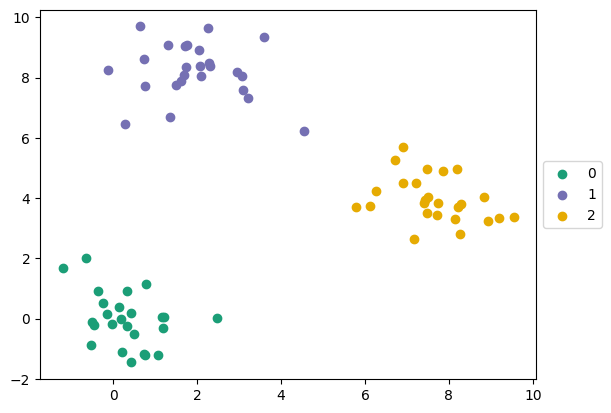

In [6]:
np.random.seed(13337)
c1 = np.random.randn(25, 2)
c2 = np.array([2, 8]) + np.random.randn(25, 2)
c3 = np.array([8, 4]) + np.random.randn(25, 2)

x1 = np.vstack((c1, c2, c3))
g1 = np.repeat([0, 1, 2], 25)

FXNscatter2d_grouped(x1, g1)

Let's just run this algorithm as a black box for the moment to see how reasonably it performs.

Algorithm converged after 2 iterations


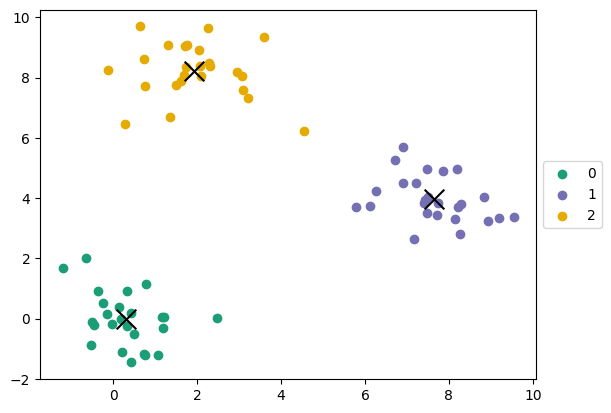

In [7]:
example1 = CLSkmeans(x1, 3)
example1.run()
example1.plot()

**Reflection Question**: You might have noticed that there's an error that's generated in the code snippet above. It's centered on the `plot()` method. Can you explore the code in the _Initial code setup_ section above and find the "bug" that causes the error and fix it? Once you've fixed it, it should make the plot for you right away!

So this generated figure looks pretty good up to the label permutation.  With such promising results, we should pry under the hood a little.  We discover that k-means clustering can be described as follows:

1. Provide initial coordinates for K cluster centers
2. Update cluster assignments
3. Update cluster centers
* Repeat 2 and 3 until satisfied


## Initialize k Cluster Centers

This seems fairly innocuous.  There seem to be a couple of ways for basic k-means to start off:

* Randomly pick k data points. The `CLSkmeans` object included in the code at the top does this by default.
* Manually enter k cluster centers.  This can be specified with the `centers` argument when instantiating the `CLSkmeans` object.

What do you think? When would you pick one method over another?

**Notation:** For the remainder of the discussion, we'll refer to the `k` clusters as $C_1, C_2, ..., C_K$ and their specific coordinates as $c_1, c_2, ..., c_K$.


## Update Cluster Assignments

How do we measure "closeness"? With k-means, we use the square euclidean distance.  Formally, for any two points $x$ and $c$, each a vector with $p$ coordinates (for the $p$ features) we can write this "dissimilarity" as:
$$d(x, c) = \lVert x-c \rVert_2^2 = \sum_{j=1}^p (x_j - c_j)^2$$

With this measure, assign each of the $n$ data points, $x_i$, $i \in \{1, 2, 3,..., n\}$, to the cluster $C_k$ that is closest to it.

It turns out that this "rule" isn't well-defined.  When is there ambiguity? How do you propose we fix this?

## Update Cluster Centers

Now that the cluster assignments have changed, we need to find their centers. This is a straightfoward calculation.  For each cluster, we just take the average of all the points assigned to that cluster:

$$c_k = \frac{1}{|C_k|}\sum_{i \in C_k} x_i$$

where $|C_k|$ is the size of the cluster.

## Repeat until satisfied

Sounds good, but when should we be satisfied?  And does our gratification come in a single lifetime? Based on the two update steps above, which stopping criteria would *you* suggest?


## Exploration: Does initialization matter?
We're in the same setting as before, but we've manually entered some initial cluster centers.  They look pretty bad but maybe k-means can salvage the situation.

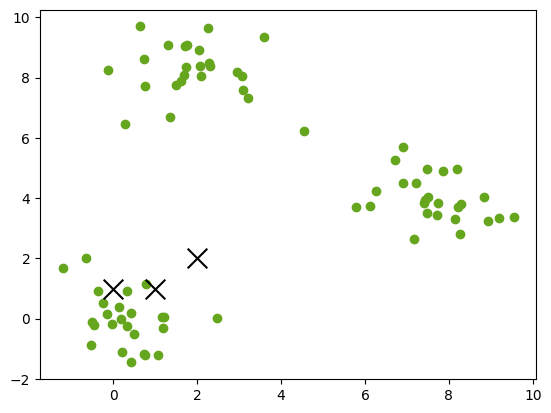

In [8]:
manual_centers = np.array([[0,1], [1,1], [2,2]])
example2 = CLSkmeans(x1, k = 3, centers = manual_centers)
example2.plot(colored=False)

We'll run the algorithm one step at a time to see what happens.  First, let's assign clusters.

Assignments:
Cluster 0: [ 1  2  3  4  5  7 10 11 12 14 15 16 17 18 19 20 23]
Cluster 1: [ 0  6  8  9 13 21 22 24]
Cluster 2: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74]




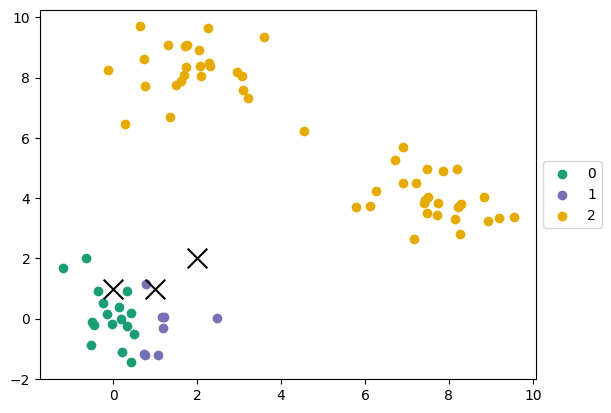

In [9]:
example2._update_clusters()
example2.show_clusters()
example2.plot()

Now to update the cluster centers.  It seems like at least one center is moving in a reasonable direction.

Centers:
Cluster 0: [-0.09206127  0.12367477]
Cluster 1: [ 1.17506256 -0.32687419]
Cluster 2: [4.79362452 6.09195594]




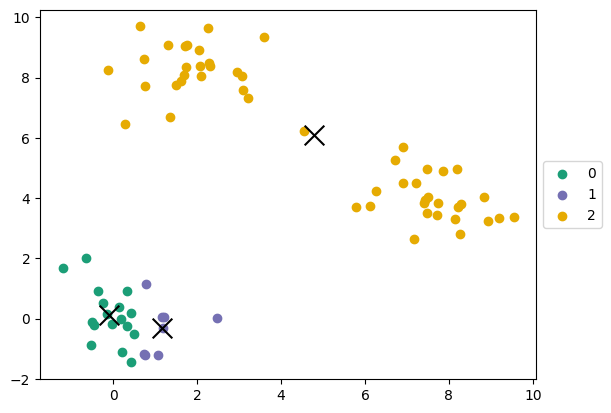

In [10]:
example2._update_centers()
example2.show_centers()
example2.plot()

Continuing with a second cluster assignment... Hmm, doesn't look like much has changed.

Assignments:
Cluster 0: [ 1  2  3  4  5 10 12 14 15 16 17 19 20 22 23]
Cluster 1: [ 0  6  7  8  9 11 13 18 21 24]
Cluster 2: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74]




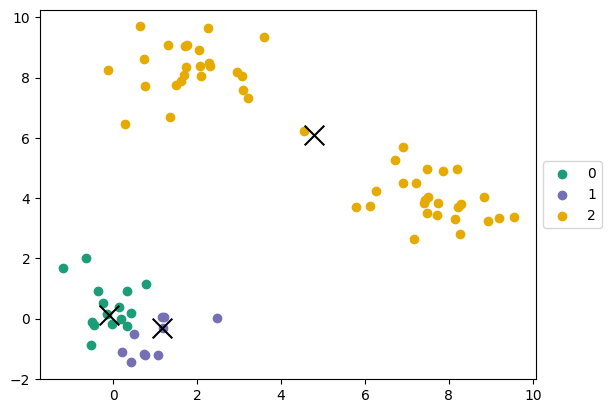

In [11]:
example2._update_clusters()
example2.show_clusters()
example2.plot()

Letting k-means run on its own reveals that we could have run this for one more step, but it still stops in a pretty bad place.  So indeed, k-means can fail to find a global optimum if it is seeded with a bad start.

Algorithm converged after 4 iterations
Current Iteration: 4
Assignments:
Cluster 0: [ 1  2  3  4  5 10 12 14 15 17 19 20 22 23]
Cluster 1: [ 0  6  7  8  9 11 13 16 18 21 24]
Cluster 2: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74]


Centers:
Cluster 0: [-0.15948704  0.46833241]
Cluster 1: [ 0.91529795 -0.64265238]
Cluster 2: [4.79362452 6.09195594]


Cluster Sum of Squares:
Cluster 0: 11.57805448512396
Cluster 1: 7.500249111430082
Cluster 2: 714.8334575461341
Total Cluster Sum of Squares: 733.9117611426882




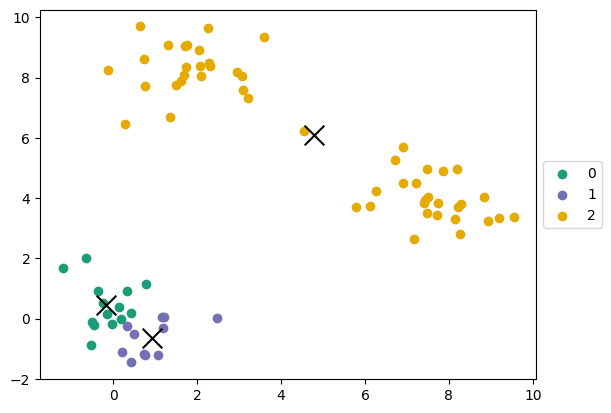

In [12]:
example2 = CLSkmeans(x1, k = 3, centers = manual_centers)
example2.run()
example2.summary()
example2.plot()

## Why k-means?
Despite its shortcomings, we should talk about its advantages:

* It's a good introduction to clustering; it's easy to explain and easy to implement.
* It's simple: there's only one easy-to-understand parameter to choose.
	* It's fast and, sometimes, rough groups can suffice for an initial analysis.
* It can be modified to be more robust; can you spot things that could be changed?


With that said, let's build some more intuition behind what the algorithm is doing.  Remember, the k-means objective function can be written as:

$$argmin_{C_1,...,C_K} \sum_{k=1}^K\sum_{i \in C_k} d(x_i, c_k) = argmin_{C_1,...,C_K} \sum_{k=1}^K\sum_{i \in C_k} \lVert x_i - c_k \rVert_2^2$$

Let's describe it in words: find the cluster assignments such that the sum of squares within clusters is minimized.  Imagine drawing squares at each data point where one vertex is on the data point and the other is on its cluster center.  Add up the area of all those squares.  That is what we're trying to minimize by shuffling the data around to different clusters.



## Implicit Preference 1

Consider the following data.  

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


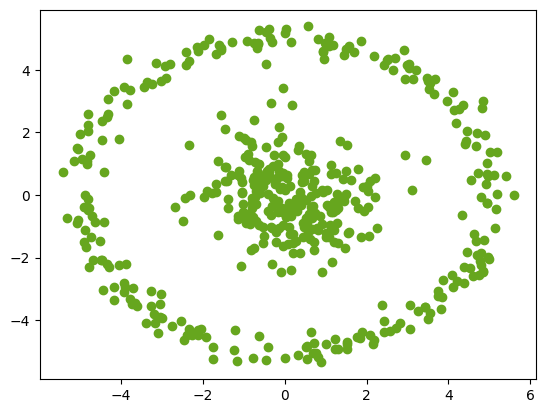

In [32]:
from google.colab import files
path = "/content/drive/MyDrive/Colab Notebooks/"
x3 = np.genfromtxt(path+'example3.csv', delimiter=',')
x3, g3 = x3[:,:2], x3[:,2]
plt.scatter(x3[:,0], x3[:,1], color=plt.cm.Dark2(.5))

# **Question 1**: Do you see any "natural" groupings?

Most people would pick out the following pattern, which doesn't seem too unreasonable.

# **Answer 1:**

Yes, I see that the data points from the outer circle have similar radial structure of data, meaning they have the same radial distance with respect from the inner circle.
Similarly, the data points from the inner circle are near to each other, so they might be part of the second cluster.

After converting the data to polar cordinates it makes more sense, because the cluster centers in the polar coordinate plot would be located at the average radial distance and angle for each cluster, which is why they appear in the middle of the vertical bars. This indicates that the K-means algorithm successfully identified and clustered the data points based on their radial structure.

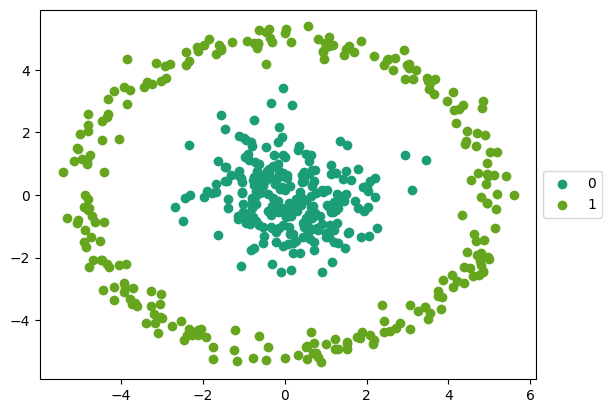

In [33]:
FXNscatter2d_grouped(x3, g3)

It turns out that k-means will pick something completely different. That pokeball though...

Algorithm converged after 19 iterations


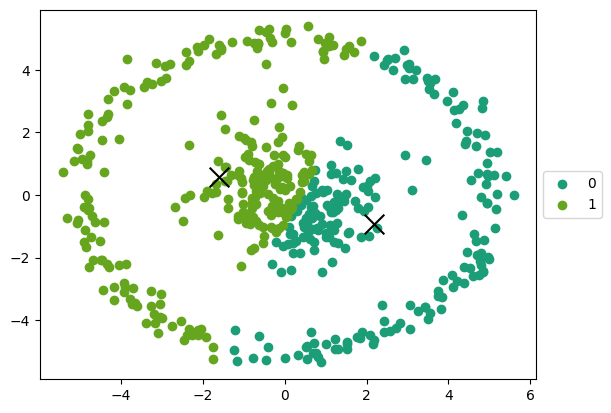

In [34]:
example3 = CLSkmeans(x3, 2)
example3.run()
example3.plot()

So what's happening here?  Remember k-mean's objective function: minimize the sum of squares within clusters.  Placing both centers at the origin and assigning the "natural" clusters would produce one "tight" cluster with small squares, but this is heavily overshadowed by the large squares resulting from the data points on the outer ring.  In other words, k-means prefers clusters that are "separate balls of points".

**Aside:** This particular situation can actually be salvaged with k-means if we want to recover the "natural" clusters by transforming the data to polar coordinates.

Algorithm converged after 5 iterations


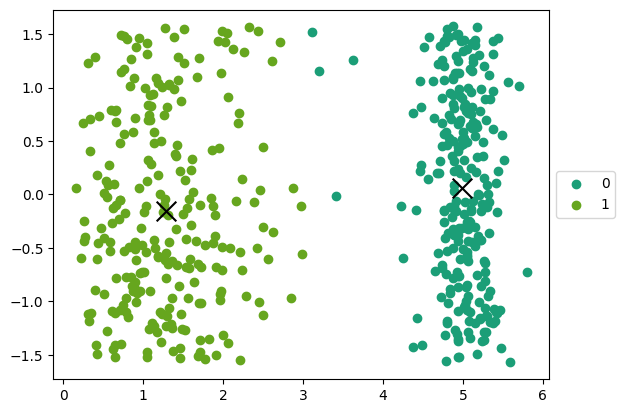

In [35]:
r = np.sqrt(x3[:,0]**2 + x3[:,1]**2)
theta = np.arctan(x3[:,0] / x3[:,1])
x3_xformed = np.hstack((r[:, np.newaxis], theta[:, np.newaxis]))
example3xf = CLSkmeans(x3_xformed, 2)
example3xf.run()
example3xf.plot()

Transforming back to cartesian coordinates:

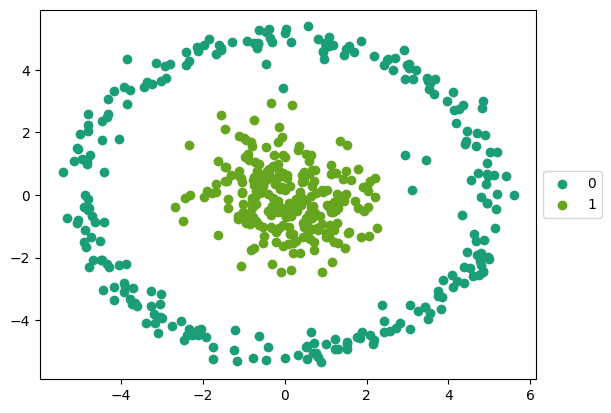

In [36]:
FXNscatter2d_grouped(x3, example3xf.clusters)

## Implicit Preference 2

Consider the data below.  There are two groups of different sizes in two different senses.  The smaller group has both smaller variability and is less numerous.  The larger of the two groups is more diffuse and populated.  

#**Question 2**: What do you think happens when we run k-means and why?

#**Answer 2:**

After running example 1, I understood that K means appears to be density sensitive. So I guessed the X markers almost in the right positions as in example4 since the bigger cluster has many more datapoints compared to the smaller one.

However, I also assumed that the left side of the original big cluster would absorb the little cluster, but I also assumed that the division between the big cluster would be more vertical instead of the negative slope that example4 shows.   

After running the K-means algorithm I also noticed that K-means also determines cluster boundaries based on the distribution of data points, and sometimes the orientation may not align with intuition.

The last example also makes sense, since the smaller cluster now has many more data points and the bigger cluster has data points more spread.

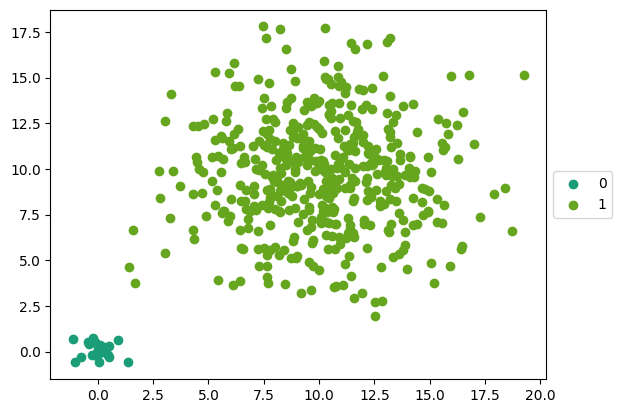

In [38]:
c1 = 0.5 * np.random.randn(25, 2)
c2 = np.array([10, 10]) + 3*np.random.randn(475, 2)

x4 = np.vstack((c1, c2))
g4 = np.repeat([0, 1], [25, 475])

FXNscatter2d_grouped(x4, g4)

It looks like it split up the larger group.  Again this is all due to the nature of the objective function. k-means, in its quest for tightness, will happily split big clouds to minimize the sum of squares.

Algorithm converged after 13 iterations


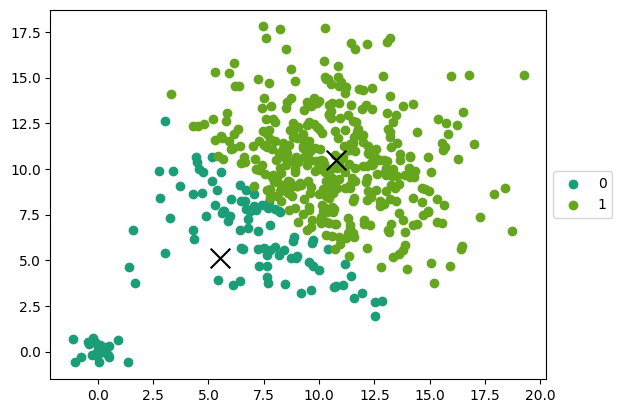

In [44]:
example4 = CLSkmeans(x4, 2)
example4.run()
example4.plot()

Even with the true centers of the data generating process chosen, we still observe the k-means **really** wants to leech points off the large cluster.

Algorithm converged after 4 iterations


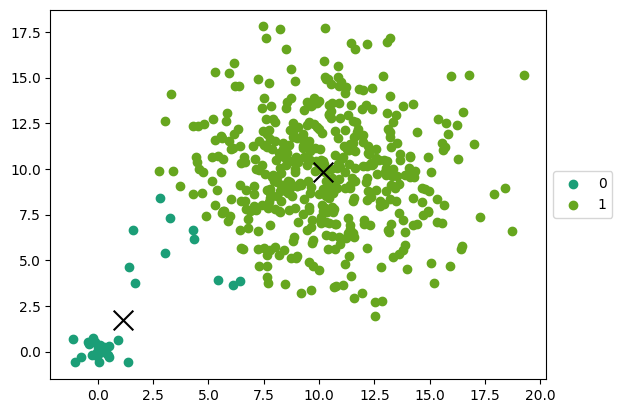

In [40]:
smart_centers = [[0, 0], [10, 10]]
example4 = CLSkmeans(x4, 2, centers = smart_centers)
example4.run()
example4.plot()

It's worth noting that this is mitigated if the different clusters are of the same size.  The inertial mass of the data keeps the cluster center from moving too far away.  Notice the outlier point that does get swallowed up in the orbit of the bottom-left cloud though.

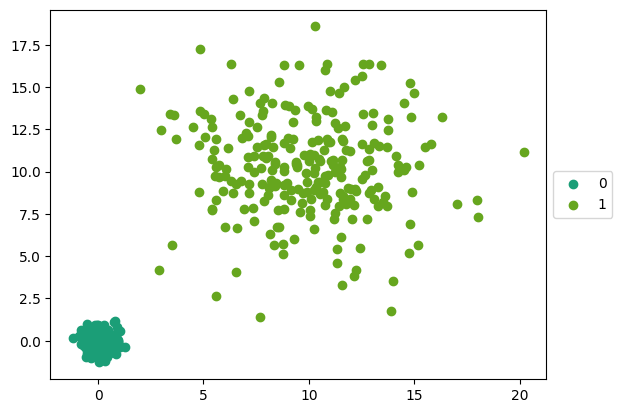

In [41]:
c1 = 0.5 * np.random.randn(250, 2)
c2 = np.array([10, 10]) + 3*np.random.randn(250, 2)

x5 = np.vstack((c1, c2))
g5 = np.repeat([0, 1], [250, 250])

FXNscatter2d_grouped(x5, g5)

Algorithm converged after 3 iterations


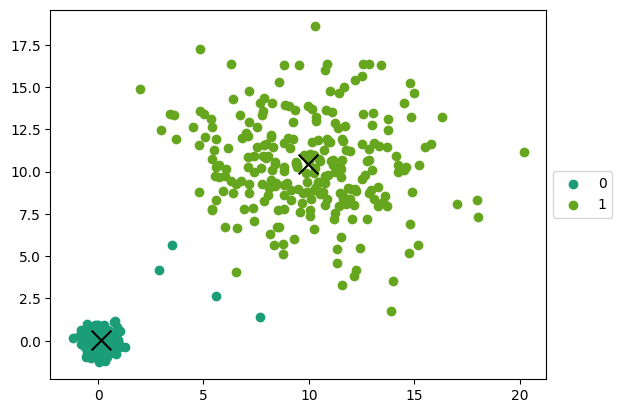

In [42]:
example5 = CLSkmeans(x5, 2)
example5.run()
example5.plot()

## Implicit Preference 3

Let's take a look at this data.  

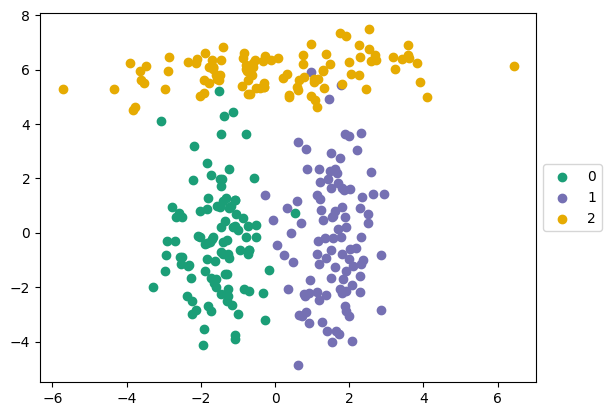

In [90]:
c1 = np.random.multivariate_normal([-1.5,0], [[.5,0],[0,4]], 100)
c2 = np.random.multivariate_normal([1.5,0], [[.5,0],[0,4]], 100)
c3 = np.random.multivariate_normal([0, 6], [[4,0],[0,.5]], 100)
x6 = np.vstack((c1, c2, c3))
g6 = np.repeat([0, 1, 2], 100)

FXNscatter2d_grouped(x6, g6)

#**Question 3**: Qualitatively, what are some properties of the groups?

There are two groups with more variability in the vertical direction than the horizontal and one group where the opposite is true.

#**Answer 3:**
As it's said above, the dataset exhibits two vertical clusters and one horizontal cluster, primarily influenced by the covariance matrices used during cluster generation. For instance, the vertical clusters are centered near [-1.5, 0] and [1.5, 0], while the horizontal cluster likely has a center near [0, 6], based on the mean values used in cluster generation.

The provided covariance matrices play an important role in determining the spread and orientation of each cluster. The covariance matrix [[0.5, 0], [0, 4]] results in a spread along the x-axis, indicated by a low variance (0.5) in the x-direction, suggesting a narrow spread. Similarly, there is a spread along the y-axis due to a higher variance (4) in the y-direction, which means a larger vertical spread.

Additionally, each cluster appears to have a similar data point density, implying that they contain a similar number of data points. Even though there are two vertical clusters and one horizontal cluster, they show a similar distance spread within their respective directions.

Sometimes the data points overlap the neighbor clusters , but this might be due to the individual cluster's spread, density, and the characteristics of the covariance matrices.

#**Question 4**: Is this an issue for k-means?  If so,  what do you think is the root cause?

#**Answer 4:**

Yes, this is an issue for the K-means, because the markers' coordinates are not consistent after running the same K means algorithm with the same input parameters.

The root cause of this issue is likely the inherent similarity in characteristics among the three original clusters.

K-means is sensitive to initial cluster centroids, and since the clusters in this dataset have similar spreads and densities, the algorithm may have difficulty consistently determining their centroids. This can result in variations in cluster assignments and, consequently, the coordinates of the markers.

I'm assuming that K means performs more reliably in cases where clusters have distinct and well-separated characteristics based on the initial examples in this lab. However, when clusters are closely packed or have similar features, it can lead to less consistent results. *italicized text*

Algorithm converged after 7 iterations


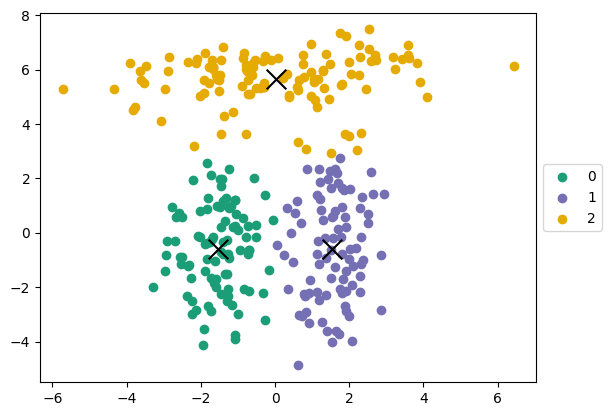

In [92]:
example6 = CLSkmeans(x6, 3)
example6.run()
example6.plot()

Algorithm converged after 8 iterations


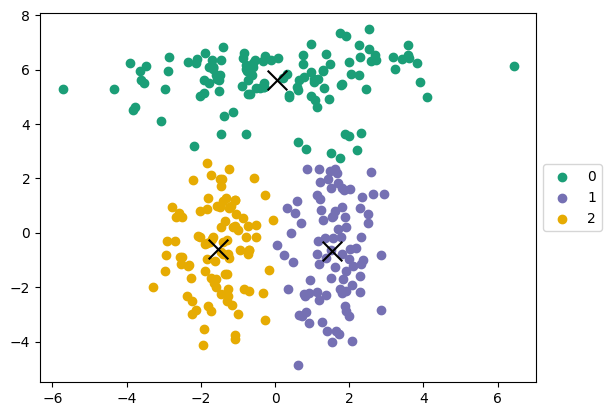

In [93]:
example6 = CLSkmeans(x6, 3)
example6.run()
example6.plot()

Algorithm converged after 5 iterations


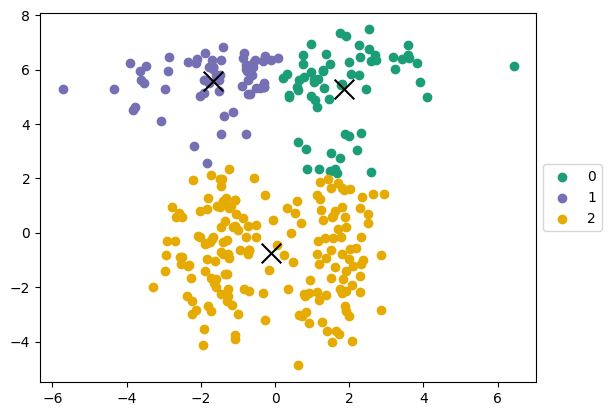

In [94]:
example6 = CLSkmeans(x6, 3)
example6.run()
example6.plot()

So indeed k-means might struggle here as well, stemming precisely from the difference in the direction of intra-group variability.  Recall that we are working with square euclidean distances.  

#**Question 5**: How might that explain these failure modes?

#**Answer 5:**

"stemming precisely from the difference in the direction of intra-group variability.  Recall that we are working with square euclidean distances."

Yes, this quote above makes sense after running the last example. In cases where clusters display different directions of variability, the algorithm appears to struggle to consistently determine the centroids. This might be because K-means primarily relies on minimizing the sum of squared distances from data points to cluster centroids, and square Euclidean distances are particularly sensitive to differences in direction.

On the other hand, when clusters have distinct and well-separated characteristics, K-means tends to perform more reliably as the centroids are easier to identify. However, in scenarios like those observed in the previous examples, where clusters have similar spreads along one axis but differ along another, the algorithm may produce varying results due to the orientation of the spread.

To conclude, the variations in cluster assignments and marker coordinates seen in these failure modes can be explained by the sensitivity of K-means to the direction of intra-group variability, especially when using square Euclidean distances.



## No Free Lunch
So we've seen a few examples where k-means fails to recover the true clusters in a plot.  Under the hood, there seems to be preference for non-overlap (see [Voronoi diagrams](https://en.wikipedia.org/wiki/Voronoi_diagram), similarly-sized groups, and equivariance ("spheres"). But perhaps we're being disingenuous here for several reasons:

1. In these examples, we know the data generating process and hence the "natural" groups.  k-means is generally viewed as an unsupervised clustering algorithm
2. We ask k-means to optimize the within-cluster sum of squares and are surprised when it "doesn't act the way we expect." It is, in fact, our expectations that are a bit out of line since in these examples, our implicit "optimal" clustering differs from k-mean's objective.
3. k-means is one of many tools. It's the analyst's job to pick the right one for the right job.

These ideas are encapsulated in what are called [No Free Lunch](https://web.archive.org/web/20220113032840/https://ti.arc.nasa.gov/m/profile/dhw/papers/78.pdf) theorems, which in a nutshell says that any optimization algorithm that is trying to solve a real question is powered by <s>hopes and dreams</s> assumptions on the real world. Treat these objects as black boxes at your own peril!